## Préparation des données

In [1]:
# Load pyspark
import findspark

findspark.init()

import os
import shutil

from pyspark import SparkContext
from pyspark.sql import SparkSession, functions as F, window

import matplotlib.pyplot as plt

import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

spark = SparkSession.builder.appName("dengue").getOrCreate()

### Chargement des données

In [2]:
path_to_data = "data/"

# features
df_features = spark.read.csv(path_to_data + "dengue_features_train.csv",
                             header=True)

# label - the output variable is 'total_cases'
df_labels = spark.read.csv(path_to_data + "dengue_labels_train.csv",
                           header=True)

#join df_features + df_labels
df_train = df_features.join(df_labels, ['city', 'year', 'weekofyear'])

# display information
print("Size of data = ({}, {})".format(df_train.count(), len(df_train.columns)))
df_train.printSchema()

Size of data = (1456, 25)
root
 |-- city: string (nullable = true)
 |-- year: string (nullable = true)
 |-- weekofyear: string (nullable = true)
 |-- week_start_date: string (nullable = true)
 |-- ndvi_ne: string (nullable = true)
 |-- ndvi_nw: string (nullable = true)
 |-- ndvi_se: string (nullable = true)
 |-- ndvi_sw: string (nullable = true)
 |-- precipitation_amt_mm: string (nullable = true)
 |-- reanalysis_air_temp_k: string (nullable = true)
 |-- reanalysis_avg_temp_k: string (nullable = true)
 |-- reanalysis_dew_point_temp_k: string (nullable = true)
 |-- reanalysis_max_air_temp_k: string (nullable = true)
 |-- reanalysis_min_air_temp_k: string (nullable = true)
 |-- reanalysis_precip_amt_kg_per_m2: string (nullable = true)
 |-- reanalysis_relative_humidity_percent: string (nullable = true)
 |-- reanalysis_sat_precip_amt_mm: string (nullable = true)
 |-- reanalysis_specific_humidity_g_per_kg: string (nullable = true)
 |-- reanalysis_tdtr_k: string (nullable = true)
 |-- station

### Nettoyage des données

In [3]:
def clean_df(df_train):

    # The 2 columns 'precipitation_amt_mm' and 'reanalysis_sat_precip_amt_mm' are the same
    # we drop 'precipitation_amt_mm'
    df_train = df_train.drop('precipitation_amt_mm')

    # recast 'week_start_date' as a date. Nice to have for plotting or time series analysis
    df_train = df_train.withColumn('week_start_date', F.to_date('week_start_date', 'yyyy-MM-dd'))

    # recast 'year' and 'weekofyear' to integer
    df_train = df_train \
        .withColumn('year', df_train['year'].cast('int')) \
        .withColumn('weekofyear', df_train['weekofyear'].cast('int'))

    # cast columns to float
    for col_name in df_train.columns[4:-1]:
        df_train = df_train.withColumn(col_name, df_train[col_name].cast('float'))

    return df_train

def convert_units(df_train):
    # convert temperature from kelvin to degree and rename variables accordingly
    df_train = df_train \
        .withColumn('reanalysis_air_temp_c', df_train['reanalysis_air_temp_k'] - 273.15) \
        .withColumn('reanalysis_avg_temp_c', df_train['reanalysis_avg_temp_k'] - 273.15) \
        .withColumn('reanalysis_dew_point_temp_c', df_train['reanalysis_dew_point_temp_k'] - 273.15) \
        .withColumn('reanalysis_max_air_temp_c', df_train['reanalysis_max_air_temp_k'] - 273.15) \
        .withColumn('reanalysis_min_air_temp_c', df_train['reanalysis_min_air_temp_k'] - 273.15) \
        .withColumn('reanalysis_tdtr_c', df_train['reanalysis_tdtr_k'] - 273.15)

    df_train = df_train \
        .drop('reanalysis_air_temp_k') \
        .drop('reanalysis_avg_temp_k') \
        .drop('reanalysis_dew_point_temp_k') \
        .drop('reanalysis_max_air_temp_k') \
        .drop('reanalysis_min_air_temp_k') \
        .drop('reanalysis_tdtr_k')
    
    return df_train

# cast column 'total_cases' (output variable) as integer
df_train = df_train.withColumn('total_cases', df_train['total_cases'].cast('int'))

# drop duplicated column and recast column to the right type
df_train = clean_df(df_train)

# convert temperatures
df_train = convert_units(df_train)

# display information
print("Size of data = ({}, {})".format(df_train.count(), len(df_train.columns)))
df_train.printSchema()

Size of data = (1456, 24)
root
 |-- city: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- weekofyear: integer (nullable = true)
 |-- week_start_date: date (nullable = true)
 |-- ndvi_ne: float (nullable = true)
 |-- ndvi_nw: float (nullable = true)
 |-- ndvi_se: float (nullable = true)
 |-- ndvi_sw: float (nullable = true)
 |-- reanalysis_precip_amt_kg_per_m2: float (nullable = true)
 |-- reanalysis_relative_humidity_percent: float (nullable = true)
 |-- reanalysis_sat_precip_amt_mm: float (nullable = true)
 |-- reanalysis_specific_humidity_g_per_kg: float (nullable = true)
 |-- station_avg_temp_c: float (nullable = true)
 |-- station_diur_temp_rng_c: float (nullable = true)
 |-- station_max_temp_c: float (nullable = true)
 |-- station_min_temp_c: float (nullable = true)
 |-- station_precip_mm: float (nullable = true)
 |-- total_cases: integer (nullable = true)
 |-- reanalysis_air_temp_c: double (nullable = true)
 |-- reanalysis_avg_temp_c: double (nullable = true)
 

In [4]:
print("Size of data = ({}, {})".format(df_train.count(), len(df_train.columns)))

# identify null value
# ===================
for col_name in df_train.columns:
    print("{} => {}".format(col_name,
                            df_train.filter(F.isnull(df_train[col_name])).count()))

Size of data = (1456, 24)
city => 0
year => 0
weekofyear => 0
week_start_date => 0
ndvi_ne => 194
ndvi_nw => 52
ndvi_se => 22
ndvi_sw => 22
reanalysis_precip_amt_kg_per_m2 => 10
reanalysis_relative_humidity_percent => 10
reanalysis_sat_precip_amt_mm => 13
reanalysis_specific_humidity_g_per_kg => 10
station_avg_temp_c => 43
station_diur_temp_rng_c => 43
station_max_temp_c => 20
station_min_temp_c => 14
station_precip_mm => 22
total_cases => 0
reanalysis_air_temp_c => 10
reanalysis_avg_temp_c => 10
reanalysis_dew_point_temp_c => 10
reanalysis_max_air_temp_c => 10
reanalysis_min_air_temp_c => 10
reanalysis_tdtr_c => 10


In [5]:
def fill_null_with_previous(df_train): 
    # Fill Null value with previous value in the column
    w = window.Window() \
        .partitionBy('city') \
        .orderBy(F.col('week_start_date'))

    for col_name in df_train.columns[4:-1]:
        df_train = df_train.withColumn(col_name, F.last(col_name, True).over(w))
    
    # last column also relevant for the test bench
    df_train = df_train.withColumn(df_train.columns[-1], F.last(df_train.columns[-1], True).over(w))

    return df_train

# replace null value in a column with value of previous cell
df_train = fill_null_with_previous(df_train)

print("Size of data = ({}, {})".format(df_train.count(), len(df_train.columns)))

# identify null value
for col_name in df_train.columns:
    print("{} => {}".format(col_name,
                            df_train.filter(F.isnull(df_train[col_name])).count()))

Size of data = (1456, 24)
city => 0
year => 0
weekofyear => 0
week_start_date => 0
ndvi_ne => 0
ndvi_nw => 0
ndvi_se => 0
ndvi_sw => 0
reanalysis_precip_amt_kg_per_m2 => 0
reanalysis_relative_humidity_percent => 0
reanalysis_sat_precip_amt_mm => 0
reanalysis_specific_humidity_g_per_kg => 0
station_avg_temp_c => 0
station_diur_temp_rng_c => 0
station_max_temp_c => 0
station_min_temp_c => 0
station_precip_mm => 0
total_cases => 0
reanalysis_air_temp_c => 0
reanalysis_avg_temp_c => 0
reanalysis_dew_point_temp_c => 0
reanalysis_max_air_temp_c => 0
reanalysis_min_air_temp_c => 0
reanalysis_tdtr_c => 0


### Plot

In [6]:
df_train_sj = df_train.filter(df_train.city == 'sj')
min_date_sj, max_date_sj = df_train_sj.select(F.min("week_start_date"), F.max("week_start_date")).first()

print("San Juan data:")
print("df_train_sj = ({}, {})".format(df_train_sj.count(), len(df_train_sj.columns)))
print("\tdate_start = {} / date_stop = {}".format(min_date_sj, max_date_sj))

df_train_iq = df_train.filter(df_train.city == 'iq')
min_date_iq, max_date_iq = df_train_iq.select(F.min("week_start_date"), F.max("week_start_date")).first()

print("Iquitos data:")
print("df_train_iq = ({}, {})".format(df_train_iq.count(), len(df_train_iq.columns)))
print("\tdate_start = {} / date_stop = {}".format(min_date_iq, max_date_iq))

San Juan data:
df_train_sj = (936, 24)
	date_start = 1990-04-30 / date_stop = 2008-04-22
Iquitos data:
df_train_iq = (520, 24)
	date_start = 2000-07-01 / date_stop = 2010-06-25


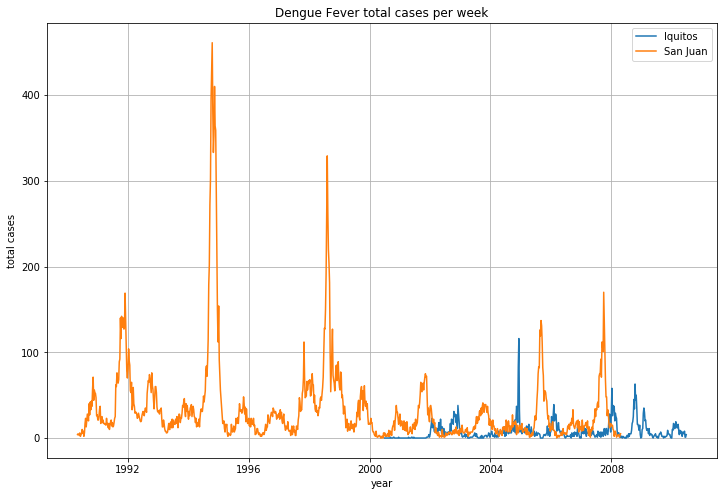

In [7]:
# Transform to pandas dataframe for plotting
pd_train_sj = df_train_sj.toPandas()
pd_train_iq = df_train_iq.toPandas()

# Total cases per city 
fig = plt.figure(figsize=(12, 8))

plt.grid()
plt.title('Dengue Fever total cases per week')

plt.xlabel('year')
plt.ylabel('total cases')
plt.xticks()
plt.yticks()

plt.plot(pd_train_iq['week_start_date'],
         pd_train_iq['total_cases'], label='Iquitos')
plt.plot(pd_train_sj['week_start_date'],
         pd_train_sj['total_cases'], label='San Juan')

plt.legend()

fig.savefig("figs/01-fig_01.pdf", dpi=300, bbox_inches='tight')
plt.show()

In [8]:
print("Size of data = ({}, {})".format(df_train.count(), len(df_train.columns)))

# save preprocessed dataframe
path_to_dir = "data/01-preprocessed"

if os.path.exists(path_to_dir) and os.path.isdir(path_to_dir):
    shutil.rmtree(path_to_dir)
    
df_train.write.parquet(path_to_dir)

Size of data = (1456, 24)


### Préparation du jeu de données test fourni par le "challenge"

In [13]:
# chargement des données
path_to_data = "data/"

df_bench = spark.read.csv(path_to_data + "dengue_features_test.csv",
                             header=True)

print("df_bench = ({}, {})".format(df_bench.count(), len(df_bench.columns)))

df_bench = (416, 24)


In [14]:
df_bench = clean_df(df_bench)
df_bench = convert_units(df_bench)
df_bench = fill_null_with_previous(df_bench)

df_bench = df_bench.withColumn("station_precip_mm", df_bench["station_precip_mm"].cast('float'))

# save preprocessed dataframe
path_to_dir = "data/01-benchmark"

if os.path.exists(path_to_dir) and os.path.isdir(path_to_dir):
    shutil.rmtree(path_to_dir)
    
df_bench.write.parquet(path_to_dir)